# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
# setup lifecycle environment

%load_ext autoreload
%autoreload 2

import logging
log = logging.getLogger(__name__)
logging.basicConfig(filename='{}.log'.format('classifier'), level=logging.DEBUG)
log.info('Initiated Logging')

from lifecycle import database
from lifecycle import models
from lifecycle import callback

log.info('creating model lifecycle class')
my_life = models.lifecycle()
mydb = database.lifecycle_db (
    username = 'projectUser',password = 'DCUpassword',
    user='brendan.bonner2@mail.dcu.ie', organisation='Dublin City University',
    lifecycle=my_life)
mydb.init_model_db()



## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:


In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  16.6M      0  0:00:47  0:00:47 --:--:-- 17.0M


In [ ]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls



Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [7]:

!ls /tmp/PetImages


Cat Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [8]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("/tmp/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 873 images


## Generate a `Dataset`


In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 13303 files belonging to 2 classes.
Using 10643 files for training.
Found 13303 files belonging to 2 classes.
Using 2660 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


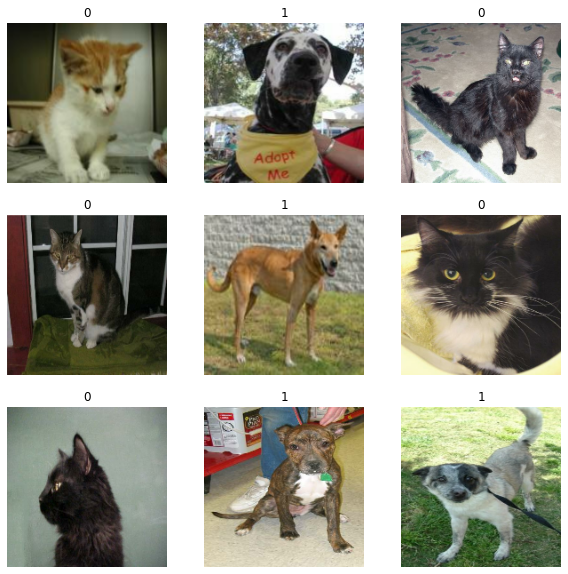

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


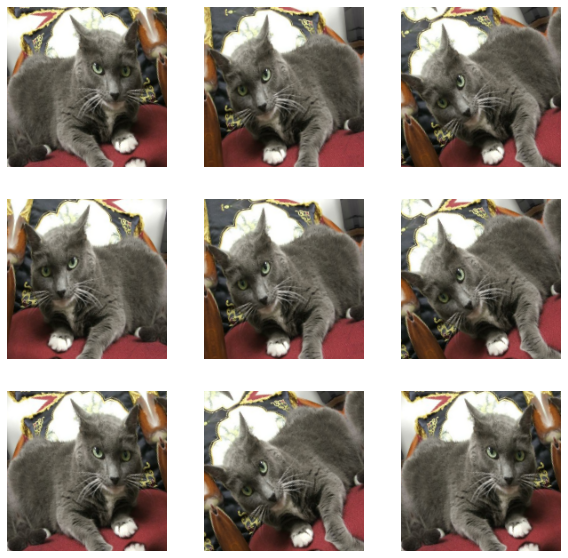

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[Keras Tuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


In [26]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x) #!!!

        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)


## Lifecycle : Add First Model to Local Repository


In [27]:
signature = mydb.push_model(model, 
    model_source = 'https://keras.io/examples/vision/image_classification_from_scratch/',
    user = 'bonnerb2',
    organisation = 'DCU',
    parent=baseline)
    
print(signature)

563ebf10f1b0ca5d849db1840add6202f4746d3e36bcaa4eda9c09b2d6503b6b


In [ ]:
class UpdateLifecycleCallback(keras.callbacks.Callback):

     def on_epoch_end(self, epoch, logs=None):
        signature = mydb.push_model(model, 
            source = 'https://keras.io/examples/vision/image_classification_from_scratch/',
            user = 'fchollet',
            organisation = 'Keras',
            parent = signature )
            
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))


    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))




## Train the model


In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


In [144]:

baseline = 'a6b385c13599f7d789becb876d20300ceb88b81f18a960252c0fc5ea9d751618'
baseline = '563ebf10f1b0ca5d849db1840add6202f4746d3e36bcaa4eda9c09b2d6503b6b'
history = mydb.get_history(baseline, full_data=True)

for m in history:

    date = m['timestamp']

    if m['data']:
#        print(m['data_diff'])
#        line = m['data_diff']
        
        graph_data_weight = []
        graph_data_skew = []
        for k,v in m['data'].items():
            graph_data_weight.append(v['weight_std'])
            graph_data_skew.append(v['skew'])

print(graph_data_weight)
   

[0, 0.2066994458436966, 0.04247795417904854, 0, 0.03222307190299034, 0.023540614172816277, 0, 0.01737615466117859, 0.012345204129815102, 0.01266847550868988, 0, 0.01005164347589016, 0.007624393329024315, 0.007955754175782204, 0, 0.00869384128600359, 0.00876055471599102, 0.008478404954075813, 0, 0, 0.0023069018498063087, 0.004384194500744343, 0.008279974572360516]


In [193]:

%matplotlib ipympl
"""
==================
Animated histogram
==================

Use histogram's `.BarContainer` to draw a bunch of rectangles for an animated
histogram.
"""

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

data_array = [
    [1,2,3,4,5,4,3,2,1],
    [1,2,3,4,5,4,3,2,1],
    [1,2,3,5,5,4,3,2,1],
    [1,2,3,5,5,4,3,2,1],
    [1,2,6,4,5,4,3,2,1],
    [1,2,6,4,5,4,3,2,1],
    [1,2,3,4,7,4,3,2,1],
    [1,2,3,4,5,8,3,2,1],
    ]
# histogram our data with numpy
data = data_array[0]
max = np.max(data_array)

###############################################################################
# To animate the histogram, we need an ``animate`` function, which generates
# a random set of numbers and updates the heights of rectangles. We utilize a
# python closure to track an instance of `.BarContainer` whose `.Rectangle`
# patches we shall update.


def prepare_animation(bar_container):

    def animate(frame_number):
        # simulate new data coming in
        array_num = np.random.random_integers(len(data_array[0]))
        data = data_array[array_num]
        data = data_array[0]
        for value, rect in zip(data, bar_container.patches):
            rect.set_height(value)
        return bar_container.patches
    return animate


print()
###############################################################################
# Using :func:`~matplotlib.pyplot.hist` allows us to get an instance of
# `.BarContainer`, which is a collection of `.Rectangle` instances. Calling
# ``prepare_animation`` will define ``animate`` function working with supplied
# `.BarContainer`, all this is used to setup `.FuncAnimation`.
print(data)

fig, ax = plt.subplots()
bar_container = ax.bar(data, width=10, height = 10, lh=1,
                              ec="lightblue", fc="lightblue", alpha=0.5)
#ax.set_ylim(top=len(data_array))  # set safe limit to ensure that all data is visible.

#ani = animation.FuncAnimation(fig, prepare_animation(bar_container), 50,
#                              repeat=False, blit=True)
plt.show()



[1, 2, 3, 4, 5, 4, 3, 2, 1]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: 'Rectangle' object has no property 'lh'

In [214]:
sig1 = '94c0166b301082fd8662144e9c70e432629597edb8deee830cb3bd2234d43931'
sig2 = '3e009b4717009534e3c009f0cad75302c3fdfec2b868c6b6fb05190da00b4ec5'
#mydb.plot_history(sig1)
mydb.plot_changes(sig1, sig2)
#mydb.compare_models(sig1, sig2)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …